# Importar librerías

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
import pmdarima as pm
import scipy.stats as ss
from statsmodels.tsa.seasonal import seasonal_decompose

#ACF y PACF
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

#test
from statsmodels.tsa.stattools import adfuller as ADF
from statsmodels.stats.diagnostic import acorr_ljungbox

## Cargar dataset

In [29]:
#Datos de temperatura
temp_data = pd.read_csv('/Users/milan/southern_hemisphere.csv',sep=";")
temp_data.tail(12)

,Date,Value
2052,2021/01,0.265
2053,2021/02,0.250
2054,2021/03,0.329
2055,2021/04,0.354
2056,2021/05,0.371
2057,2021/06,0.342
2058,2021/07,0.476
2059,2021/08,0.481
2060,2021/09,0.437
2061,2021/10,0.453


In [3]:
#Se transforma la fechas del dataset en el index.
index= pd.to_datetime(temp_data['Date'],format='%Y/%m',errors='coerce')
temp = pd.Series(temp_data['Value'].values.tolist(), index = index)
temp

Date
1850-01-01   -0.555
1850-02-01   -0.522
1850-03-01   -0.760
1850-04-01   -0.540
1850-05-01   -0.234
              ...  
2021-08-01    0.481
2021-09-01    0.437
2021-10-01    0.453
2021-11-01    0.426
2021-12-01    0.377
Length: 2064, dtype: float64

### Se ve como despliegan los datos

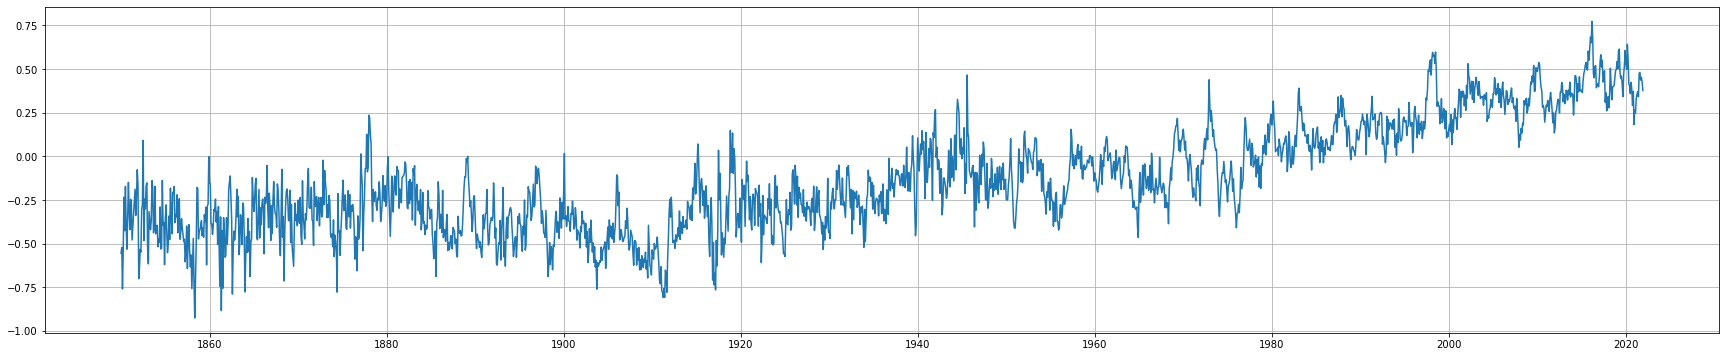

In [4]:
plt.figure(figsize = (30,6))
plt.grid()
plt.plot(temp, label='datos recolectados')

* Se observa que las máximas del siglo 19 tienen a rondar a 0, con ciertas excepcciones.
* Se observa que con el paso del tiempo al llegar al siglo 21 las máximas y mínimas están por encima de 0

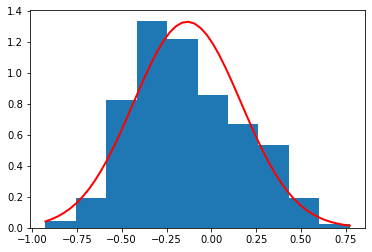

In [5]:
plt.hist(temp, density=True, label="Data")
mn = temp.min()
mx = temp.max()
rv = ss.norm(np.mean(temp), np.std(temp))
x = np.linspace(mn,mx)
plt.plot(x, rv.pdf(x), lw=2, color="red");

# Descomposición aditiva

<Figure size 864x432 with 0 Axes>

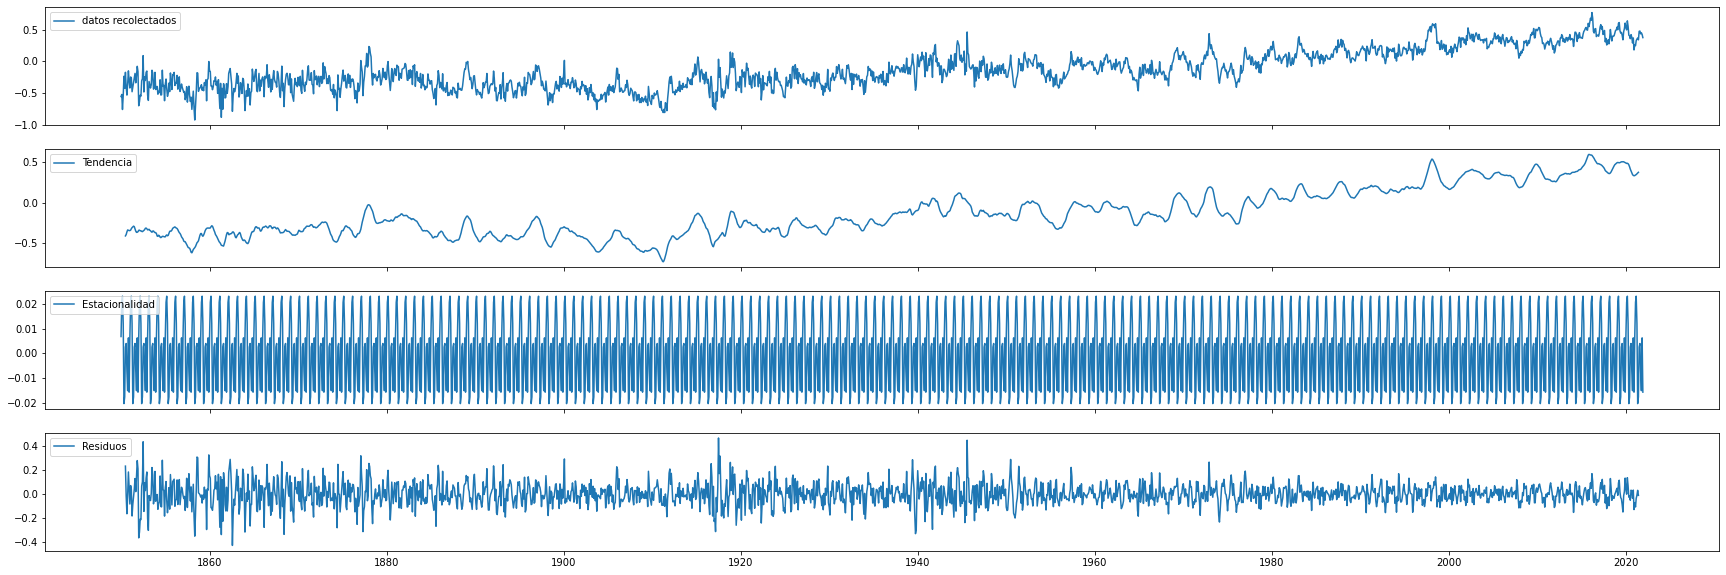

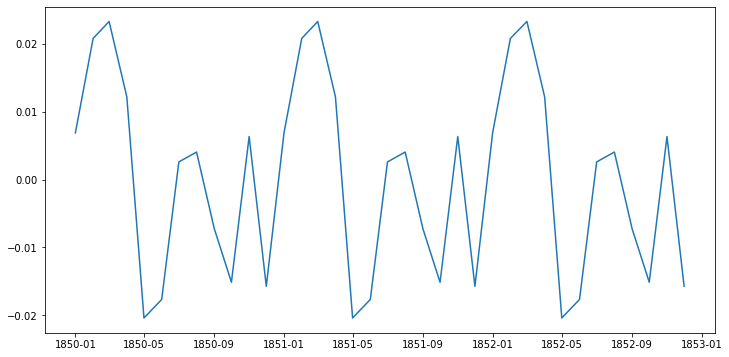

In [6]:
fr=temp
plt.figure(figsize = (12,6))
result=seasonal_decompose(fr, model='additive', period=12)
trend_estimate = result.trend
seasonal_estimate = result.seasonal
residual_estimate = result.resid

fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)
fig.set_figheight(10)
fig.set_figwidth(30)
# First plot to the Original time series
axes[0].plot(fr, label='datos recolectados') 
axes[0].legend(loc='upper left');
# second plot to be for trend
axes[1].plot(trend_estimate, label='Tendencia')
axes[1].legend(loc='upper left');
# third plot to be Seasonality component
axes[2].plot(seasonal_estimate, label='Estacionalidad')
axes[2].legend(loc='upper left');
# last last plot to be Residual component
axes[3].plot(residual_estimate, label='Residuos')
axes[3].legend(loc='upper left');
plt.show()
plt.figure(figsize = (12,6))
plt.plot(seasonal_estimate[:36], label='Estacionalidad')

* Se muestra una estacionalidad marcada por las estaciones y periodos del año. Verano tiene un incremento de la temperatura e invierno baja.
* Se cree que hay una tendencia hacia el incremento de las temperatudas con le paso del tiempo. Esto apoya en cierta medida las ideas inicialmente descritas al inicio, cuando cargue el dataset.
* La muestra se mueve en un comportamiente definido y sin picos, por tanto se sospecha que la muestra posee una baja heterocedasticidad.


In [45]:
df=temp
df=df.diff(1).dropna()
adf_test= ADF(df)
white_noise_test1=acorr_ljungbox (df, lags = 1)
white_noise_test2=acorr_ljungbox (temp, lags = 1)
print ('el resultado de la prueba ADF de secuencia original es:', adf_test)
 # Los valores de retorno son adf, pvalue, usedlag, nobs, valores críticos, icbest, regresults, restore
print (u'Ruido blanco al data set con diff', white_noise_test1[1],u'Ruido blanco al data set sin diff', white_noise_test2[1])
 # Estadísticas de devolución y valores p 

el resultado de la prueba ADF de secuencia original es: (-14.288080982085997, 1.2895947466396586e-26, 22, 2040, {'1%': -3.4335595821169127, '5%': -2.8629578358389685, '10%': -2.5675247926278355}, -3341.7009838081476)
Ruido blanco al data set con diff [3.87502166e-54] Ruido blanco al data set sin diff [0.]


C:\Users\milan\anaconda3\lib\site-packages\statsmodels\stats\diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


* Ahora es estacionaria ( p value 1.2895947466396586e-26 < 0.05)
* No hay ruido blanco, no quedo en el documento pero al hacer la prueba de ruido blanco sin 
 * Con diferencia aplicada( p value 3.87502166e-54 < 0.05)
 * Sin diff( p value 0 < 0.05), se observa una muy alta autorrelación entre la serie de tiempo y sus versiones rezagadas/Lageadas
* La diferenciación para el proceso ARIMA debería ser de orden 1 como mínimo

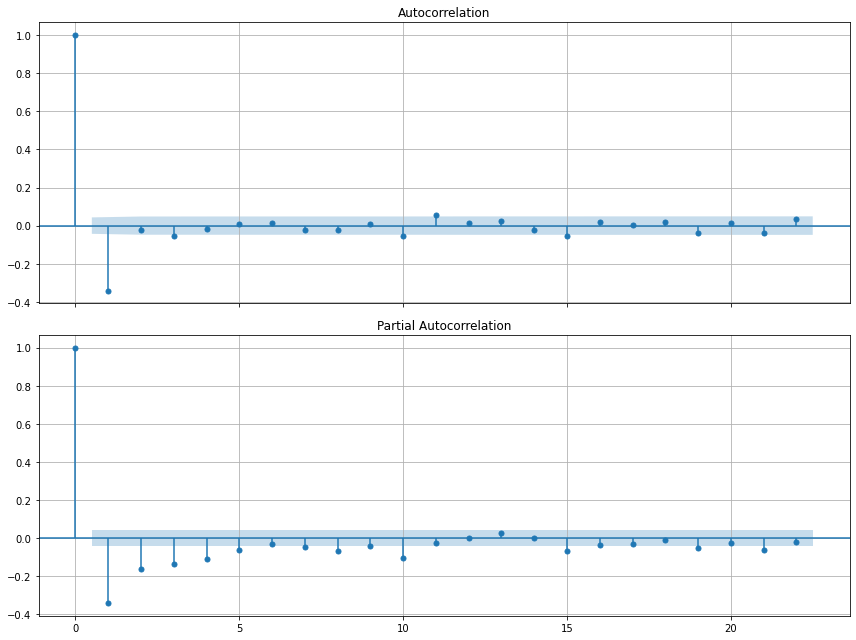

In [8]:
lag = 22
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 9), 
                       sharex=True, sharey=False)
plot_acf(df, lags= lag, ax=ax[0])
ax[0].grid()
plot_pacf(df,lags=lag, ax=ax[1], method='yw')
ax[1].grid()
plt.tight_layout()
plt.show()

* Por la gráfica de autocorrelación deberiamos trabajar con la media movil de 1 LAG
* En la gráfica de autocorrelación parcial deberiamos trabajar con el proceso autoregresivo hasta 5 LAG, probablemente no pasemos del 3

# ARIMA

**Teniendo en cuenta la información anterior, esperamos que mejor modelo para el ARIMA es (2,1,1)**

In [9]:
df=temp
size= int(len(df)*0.8)
test,train =  df[size:], df[:size]
train.shape,test.shape
model_no_m = pm.auto_arima(train, trace=True, error_action='ignore', suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-2463.712, Time=1.78 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2095.205, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2300.141, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2389.633, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2097.176, Time=0.20 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-2472.280, Time=1.86 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-2411.666, Time=0.68 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2426.441, Time=0.90 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-2471.724, Time=2.00 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-2428.002, Time=0.83 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-2460.120, Time=1.44 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-2454.517, Time=2.29 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-2472.004, Time=0.58 sec

Best model:  ARIMA(1,1,2)(0,0,0)[0] intercept
Total fit time: 13.079 seconds


**Finalmente el mejor modelo indicado por la prueba de autoarima es (1,1,2), pero investigando se descubrío un detalle de la librería donde en base a la naturaleza de los datos y los ciclos estacionarios hay que declarar una variable que mejora el indice de la prueba**

* En este caso colocaré la variable m = 12 en un segundo dataset para validar el desempeño de las predicciones contra el primero modelo

In [10]:
model_m12 = pm.auto_arima(train, trace=True, error_action='ignore', suppress_warnings=True,m=12)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=-2433.458, Time=5.82 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-2095.205, Time=0.14 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-2301.352, Time=0.74 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-2389.978, Time=1.40 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-2097.176, Time=0.21 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=-2435.463, Time=5.24 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=-2463.712, Time=1.81 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=-2435.393, Time=6.10 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=-2472.280, Time=1.81 sec
 ARIMA(1,1,2)(1,0,0)[12] intercept   : AIC=-2457.257, Time=4.17 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=-2473.598, Time=4.44 sec
 ARIMA(1,1,2)(1,0,1)[12] intercept   : AIC=-2470.301, Time=5.09 sec
 ARIMA(1,1,2)(0,0,2)[12] intercept   : AIC=-2429.642, Time=13.53 sec
 ARIMA(1,1,2)(1,0,2)[12] intercept   : AIC=-2475.071, Time=19.01 sec
 AR

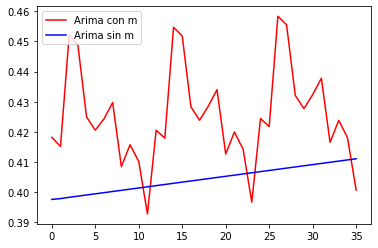

In [32]:
pred_m12= model_m12.fit_predict(test,n_periods=36)
pred_no_m= model_no_m.fit_predict(test,n_periods=36)
plt.plot(pred_m12,color="red",label='Arima con m')
plt.plot(pred_no_m,color="blue",label='Arima sin m')
plt.legend(loc='upper left', fontsize=10)
plt.show()

**Se destacan varias cosas importantes:**
* La predicción del arima con M es (1,1,2)(2,0,1)[12] donde:
 * (2,0,1) son variables de estacionalidad derivadas del proceso de autoregresión, diferencia y media móvil del ARIMA
 * 12 es el ciclo de la estacionalidad representada por el ciclo anual visto al inicio del ejercicio.
* Las predicciones con m tienen un comportamiento más realista en comparación al arima sin M, el cual termina cierto más una recta.

**En resumen, preferíre trabajar con las variables estacionarias para obtener una mejor predicción(Modelo con m=12)**

## Datos reales VS Predicción de los datos VS Pronóstico hacía el futuro
A continuación se hace una comparación:

C:\Users\milan\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\milan\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\milan\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


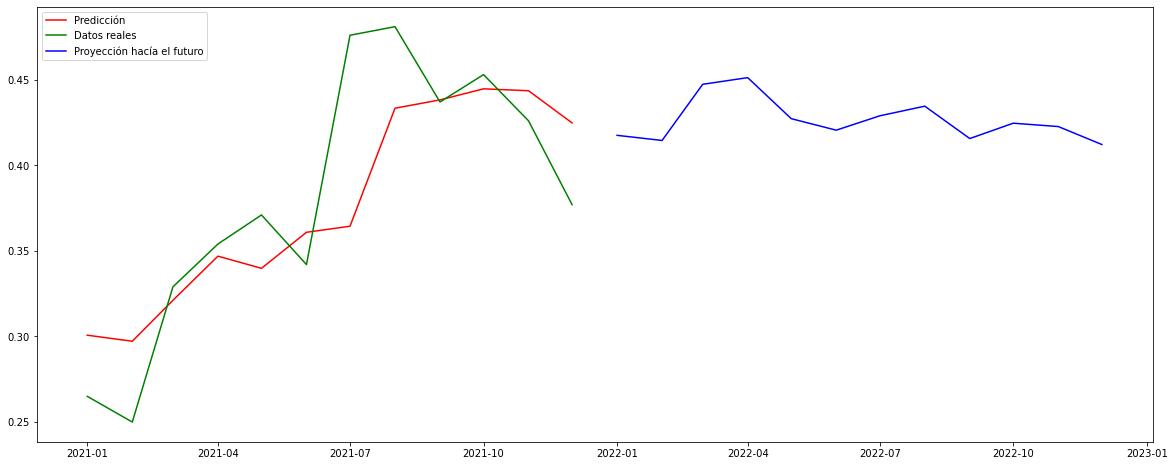

In [39]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(df, order=(1,1,2),seasonal_order=(2,0,1,12)) # Definir el modelo
model_fit = model.fit() #Ajustar el modelo

start="2021-01-01"
end="2021-12-01"
#Predicción
y_pred = model_fit.predict(start=start,end=end)
plt.figure(figsize = (20,8))
plt.plot(y_pred,color="red",label='Predicción')
plt.plot(df[start:end],color="green",label='Datos reales')
plt.plot(model_fit.forecast(12, alpha=0.05),color="blue",label='Proyección hacía el futuro')
plt.legend(loc='upper left', fontsize=10)
plt.show()

**Pregunta 1:**
Describa los datos efectuando un gráfico de la serie de tiempo presentada.
* Se observa que las máximas del siglo 19 tienen a rondar a 0, con ciertas excepcciones.
* Se observa que con el paso del tiempo al llegar al siglo 21 las máximas y mínimas están por encima de 0
*
**Pregunta 2:**
Efectúe una descomposición aditiva de la serie de tiempo presentada y muestre los gráficos correspondien-
tes. Además muestre los graficos de la auto correlación y auto correlación parcial. Comente los resultados,
existe alguna correlación temporal?
* Existe una alta autocorrelación en los datos presentados según las pruebas de ruido blanco. 
* La muestra tiene una estacionalidad marcada.
* Existe una tendencia hacia el incremento de las temperaturas.
* Por la gráfica de autocorrelación deberiamos trabajar con la media movil de 1 LAG
* En la gráfica de autocorrelación parcial deberiamos trabajar con el proceso autoregresivo hasta 5 LAG, probablemente no pasemos del 3

**Pregunta 3:**
Ajuste un modelo ARIMA(p,d,q) a la serie de tiempo presentada. Puede emplear auto arima para tales
efectos, comente respecto a los parámetros encontrados del modelo, es decir, los valores de p, d y q.
* pensé inicialmente que (2,1,1) sería el arima correcto, pero según autoarima al final es (1,1,2).
* Con el autoestudio que apliqué aprendí otras configuraciones que agregan mejoras al desempeño del autoarima consiguiendo las siguientes componentes estacionarios para p, d y q
 * (2,0,1)[12]
* Al final el arima utilizado es (1,1,2)(2,0,1)[12].

**Pregunta 4:**
En función del problema. ¿Puede la componente de tendencia indicar un aumento en la temperatura del
mar?.
* Lamentablemente si, la tendencia respalda la observación vista al validar el comportamiento de los datos. Las tendencias de temperatura al inicio de la serie de tiempo son negativas y al acercarse a la actualidad pasan a ser por valores positivos.